## Based on the given data, will a customer subscribe to a term deposit or not? 
#### Data Description:
The data is related to the direct marketing campaigns of a Portuguese banking institution.
The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be (‘yes’) or not (‘no’) subscribed. 

We will be using Ensemble and other Techniques to arrive at the solution.  The domain is Banking sector.

In [1]:
#from pyforest import*
# lazy_imports()

In [2]:
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import pandas_profiling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
#from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
#from xgboost import XGBClassifier 
#from sklearn import svm
#from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
import sklearn.metrics as metrics
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

%matplotlib inline

In [3]:
#### Now Load the dataset and read the first 10 rows of data as a dataframe
df = pd.read_csv('bank-full.csv')
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


### EXPLORATORY DATA ANALYSIS

In [4]:
#check the size of the dataset 
print('Dataset has {} Number of rows'.format(df.shape[0])) 
print('Dataset has {} Number of columns'.format(df.shape[1]))

Dataset has 45211 Number of rows
Dataset has 17 Number of columns


In [5]:
# get the datatype of all the columns in the dataset
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
Target       object
dtype: object

In [6]:
# select categorical and numerical features
cat_df = df.select_dtypes(include=['object', 'bool']).columns
num_df = df.select_dtypes(include=['int64', 'float64']).columns
print(cat_df), (num_df)

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome', 'Target'],
      dtype='object')


(None,
 Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object'))

In [7]:
# Checking for Missing Values (#isnull() can also be used - df.isnull()).sum())
# Percentage and Sum of Missing values in each Columns
missing_data = pd.DataFrame({'TotalMissing': df.isna().sum(), 'PercentageMissing': (df.isna().sum()/df.shape[0])*100})
missing_data

,TotalMissing,PercentageMissing
age,0,0.0
job,0,0.0
marital,0,0.0
education,0,0.0
default,0,0.0
balance,0,0.0
housing,0,0.0
loan,0,0.0
contact,0,0.0
day,0,0.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
Target       45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [9]:
#point summary of numerical attributes
pd.set_option('precision', 4)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.9362,10.6188,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.2721,3044.7658,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.8064,8.3225,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.1631,257.5278,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.7638,3.0980,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.1978,100.1287,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.5803,2.3034,0.0,0.0,0.0,0.0,275.0


In [10]:
#check if the data is balanced or imbalanced (let's check the Target distribution)
df['Target'].value_counts()

no     39922
yes     5289
Name: Target, dtype: int64

### DATA VISUALIZATIONS

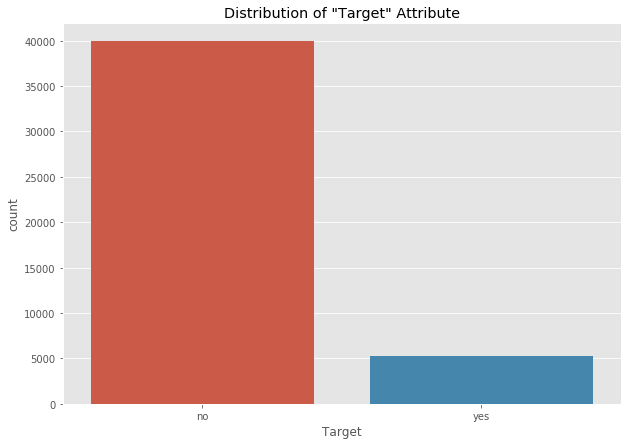

In [11]:
# By looking at the above count, 39922 values of target column is No and 5289 values of target column is Yes which makes this a imbalanced dataset.
#### Also Visualize this count 
plt.figure(figsize=(10,7))
plt.title('Distribution of "Target" Attribute')
sns.countplot(df['Target'],label="Count")
#sns.distplot(df['Target'],color='red'); # this can be used only after converting target to numerical value

In [12]:
##label encoding - In this section we encode the categorical data in the bank dataset by using LabelEncoder
from sklearn.preprocessing import LabelEncoder
df1 = df.copy() #making a copy of the original dataset and not disturbing the original dataset

#df1.iloc[:,16]=labelencoder_Y.fit_transform(df1.iloc[:,16].values)

# select categorical and numerical features
cat_df = df1.select_dtypes(include=['object', 'bool']).columns
num_df = df1.select_dtypes(include=['int64', 'float64']).columns

# label encode the target variable to have the classes 0 and 1
#y = LabelEncoder().fit_transform(y)
le = LabelEncoder()
df1 = df1.apply(le.fit_transform)

In [13]:
#to check how target columnn looks now after using labelEncoder
df1.tail(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
45201,35,4,1,2,0,1499,0,0,0,16,9,226,0,181,4,2,1
45202,16,0,2,1,0,1473,0,0,0,16,9,224,0,0,0,3,1
45203,5,8,2,2,0,1029,0,0,0,16,9,266,0,0,0,3,1
45204,55,5,1,1,0,3678,0,0,0,16,9,300,0,37,8,0,1
45205,7,9,2,1,0,1421,0,1,0,16,9,386,1,0,0,3,1
45206,33,9,1,2,0,1741,0,0,0,16,9,975,2,0,0,3,1
45207,53,5,0,0,0,2639,0,0,0,16,9,456,1,0,0,3,1
45208,54,5,1,1,0,5455,0,0,0,16,9,1116,4,181,3,2,1
45209,39,1,1,1,0,1584,0,0,1,16,9,508,3,0,0,3,0
45210,19,2,1,1,0,3779,0,0,0,16,9,361,1,185,11,1,0


In [14]:
#check datatypes now after using labelencoder
print(df1.dtypes)

age          int64
job          int32
marital      int32
education    int32
default      int32
balance      int64
housing      int32
loan         int32
contact      int32
day          int64
month        int32
duration     int64
campaign     int64
pdays        int64
previous     int64
poutcome     int32
Target       int32
dtype: object


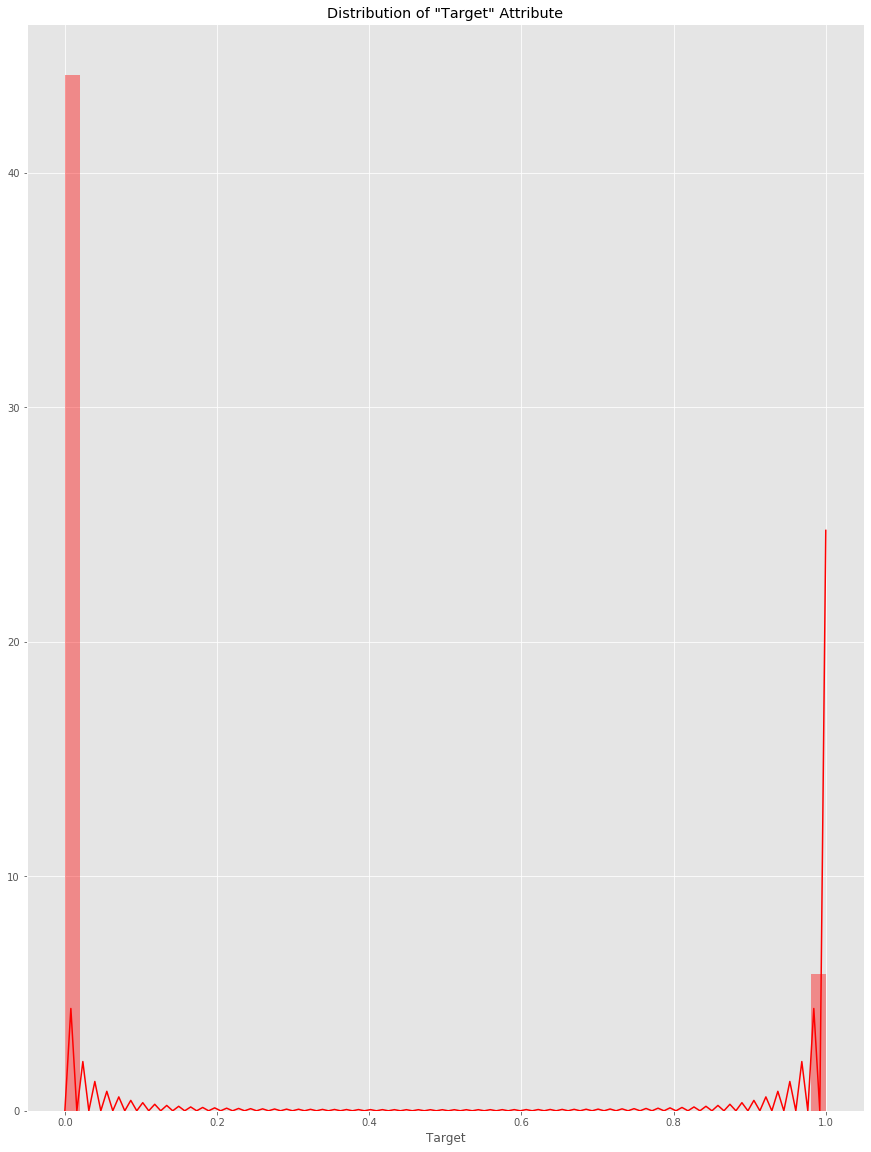

In [15]:
# checking the distribution of Target Attribute after converting Target (categorical to numerical so that sns.displot can be used)
plt.figure(figsize=(15,20))
plt.title('Distribution of "Target" Attribute')
sns.distplot(df1['Target'],color='red'); 

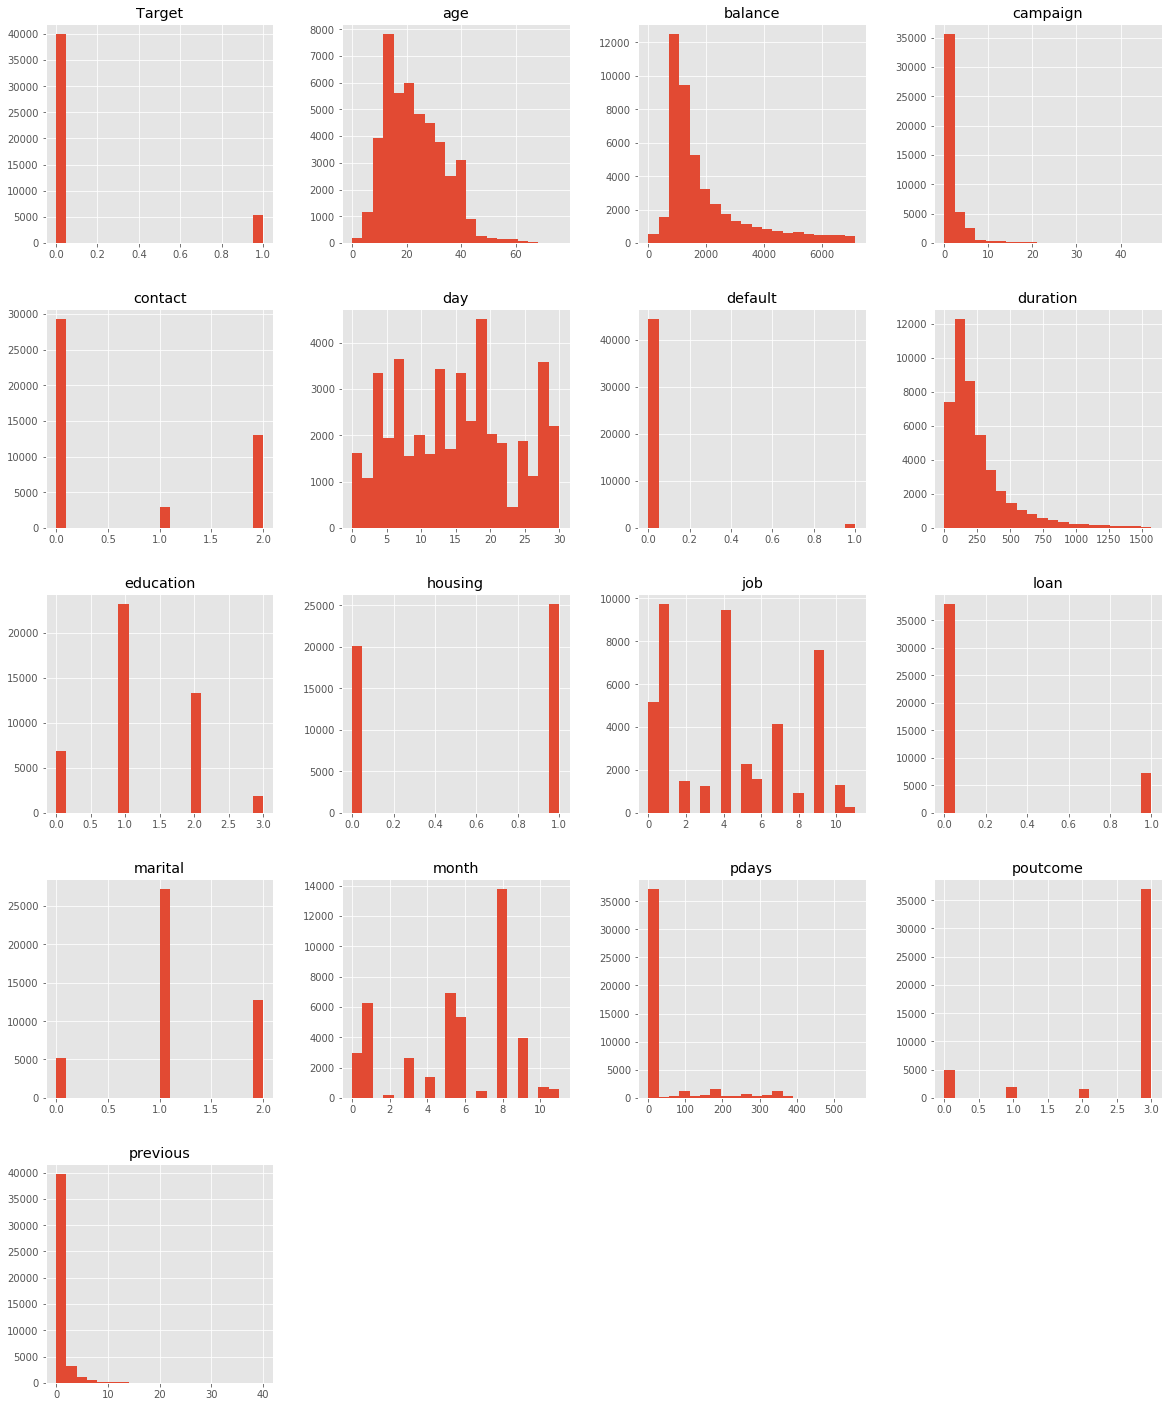

In [16]:
df1.hist(bins=20,figsize=(20,25));

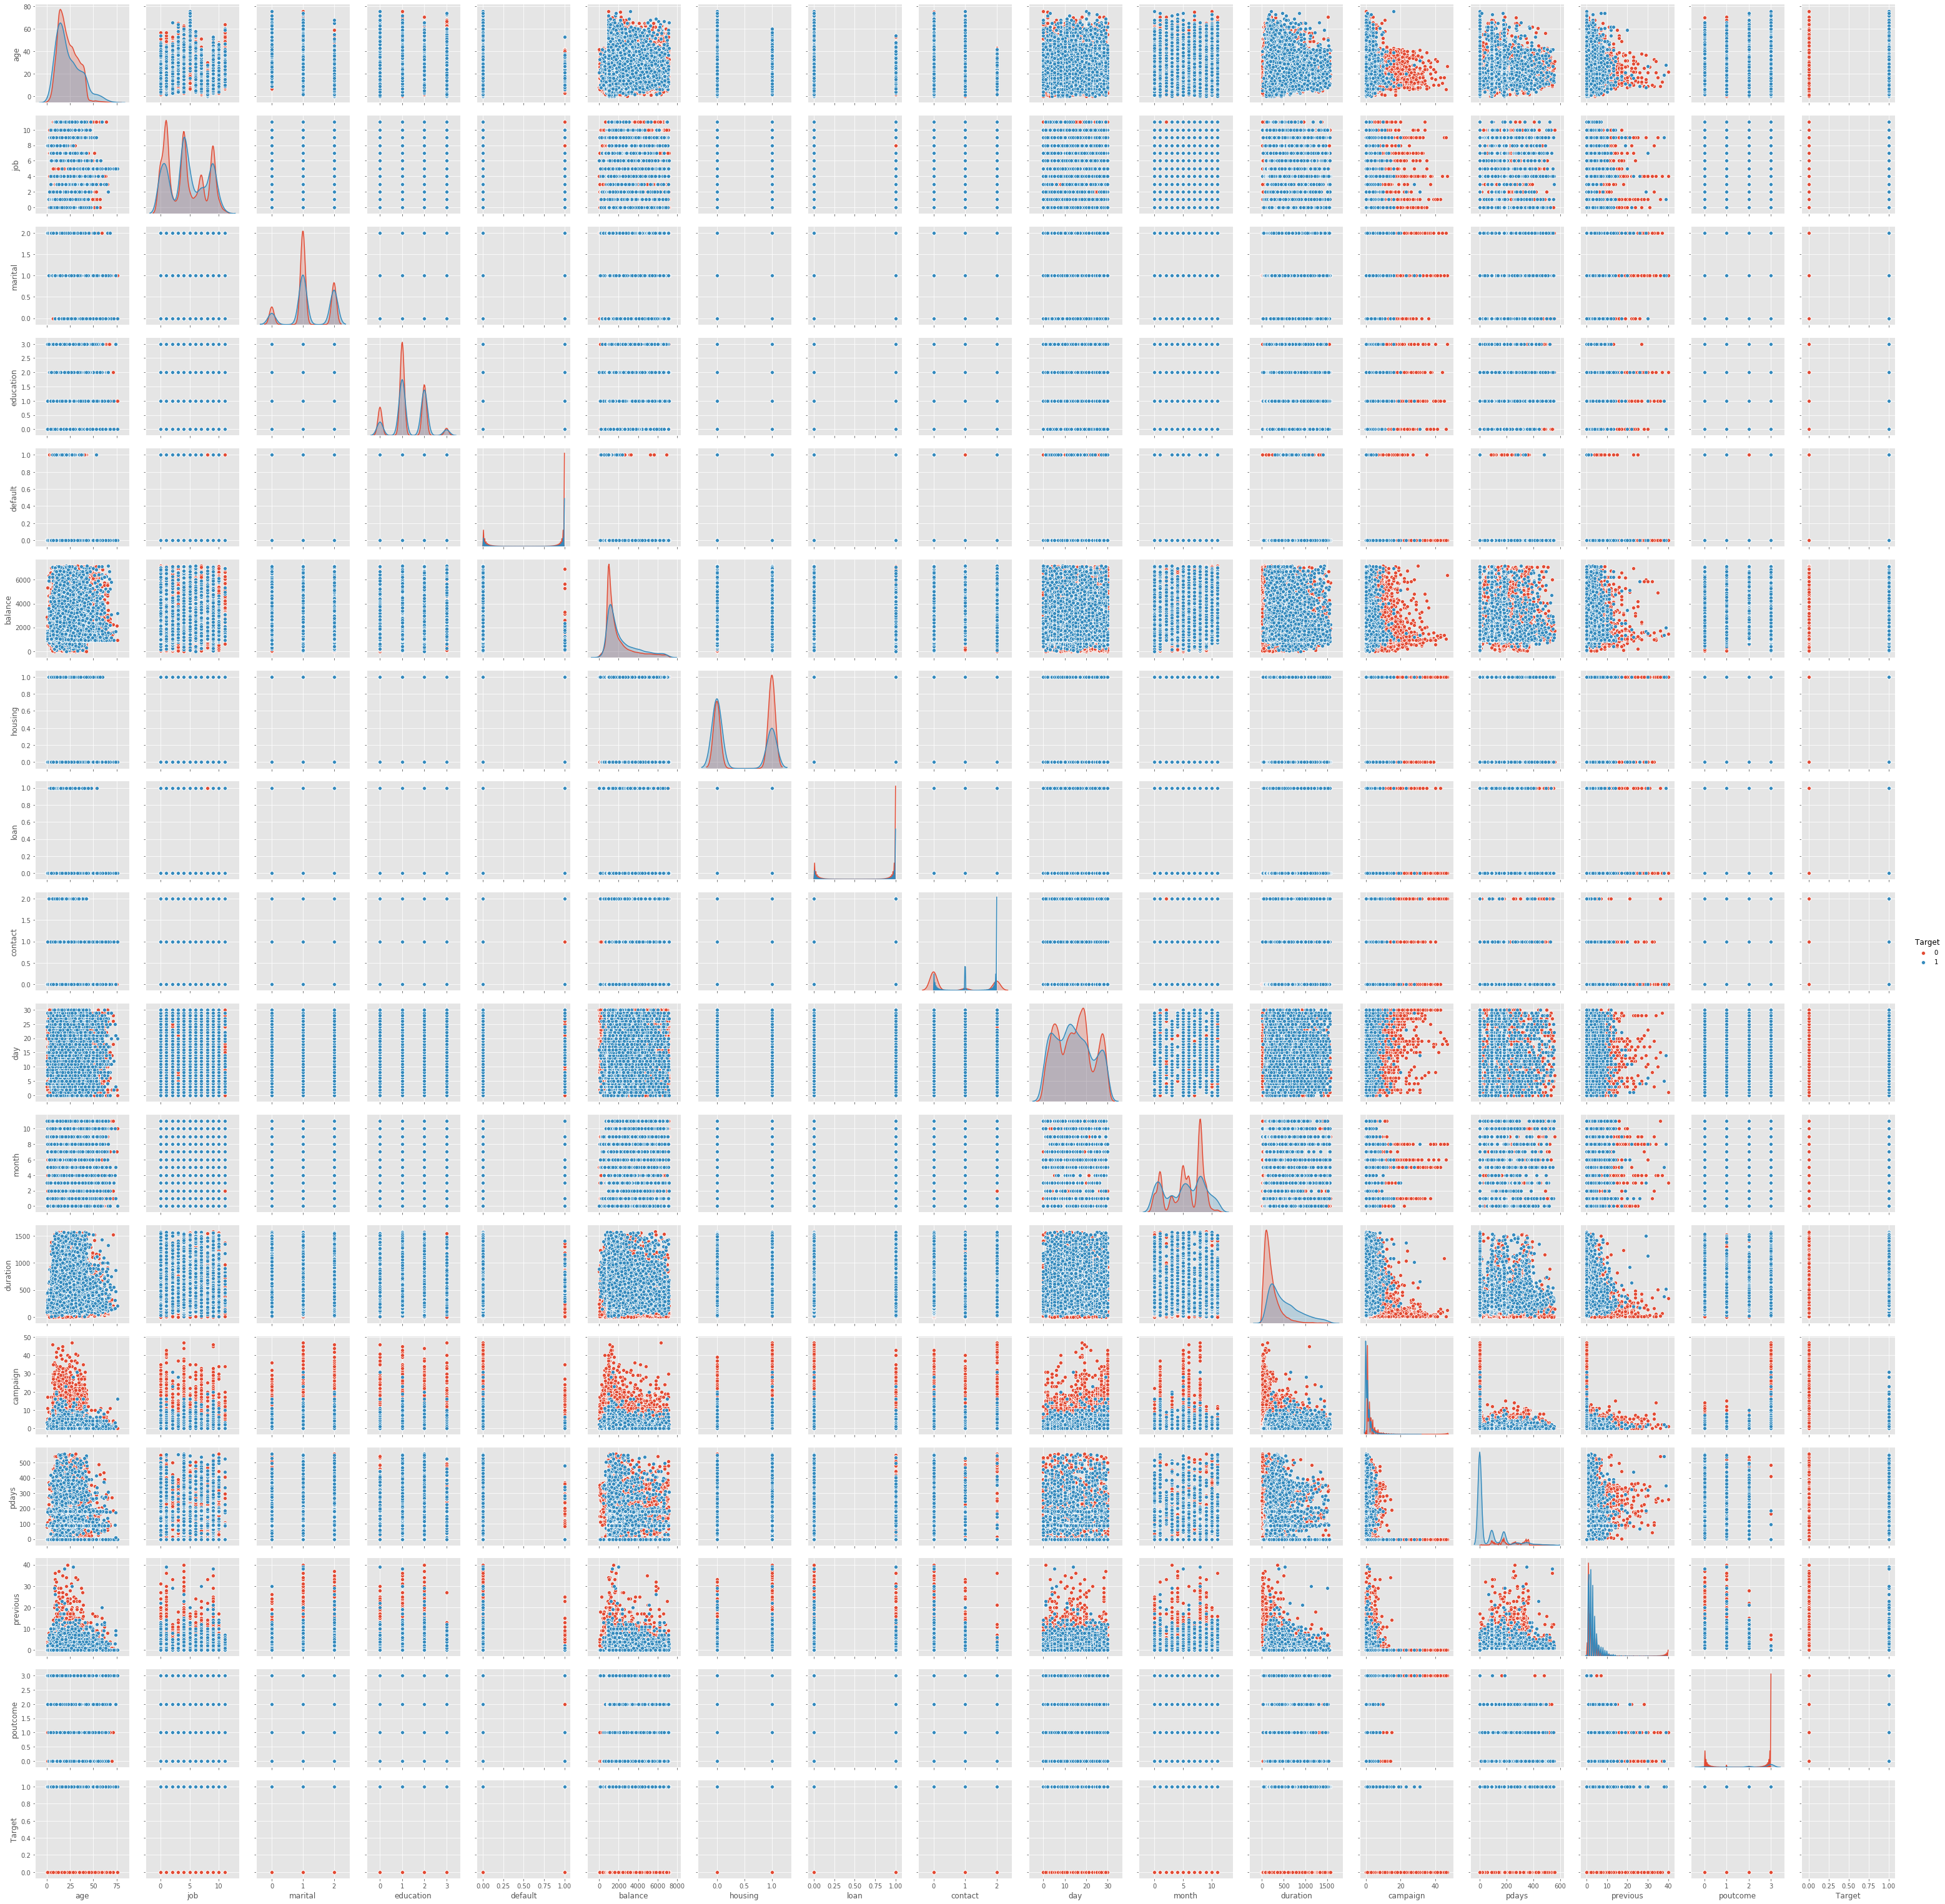

In [17]:
#let us do a pairplot
sns.pairplot(df1,hue='Target')

In [18]:
#Lets do a Correlation matrix of all the columns to see how strongly the columns are related to each other
df1.corr()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
age,1.0000,-0.0219,-0.4033,-0.1068,-0.0179,0.1191,-0.1855,-0.0157,0.0262,-0.0091,-0.0424,-0.0068,0.0050,-0.0244,0.0021,0.0074,0.0251
job,-0.0219,1.0000,0.0620,0.1667,-0.0069,0.0260,-0.1254,-0.0330,-0.0821,0.0229,-0.0929,0.0041,0.0069,-0.0251,-0.0009,0.0110,0.0404
marital,-0.4033,0.0620,1.0000,0.1086,-0.0070,0.0069,-0.0161,-0.0469,-0.0392,-0.0053,-0.0070,0.0124,-0.0092,0.0196,0.0188,-0.0169,0.0456
education,-0.1068,0.1667,0.1086,1.0000,-0.0107,0.0715,-0.0908,-0.0486,-0.1109,0.0227,-0.0573,0.0023,0.0062,-0.0014,0.0189,-0.0194,0.0662
default,-0.0179,-0.0069,-0.0070,-0.0107,1.0000,-0.1057,-0.0060,0.0772,0.0154,0.0094,0.0115,-0.0095,0.0170,-0.0300,-0.0220,0.0349,-0.0224
balance,0.1191,0.0260,0.0069,0.0715,-0.1057,1.0000,-0.0789,-0.1141,-0.0361,0.0109,0.0239,0.0383,-0.0260,0.0123,0.0396,-0.0412,0.0829
housing,-0.1855,-0.1254,-0.0161,-0.0908,-0.0060,-0.0789,1.0000,0.0413,0.1881,-0.0280,0.2715,0.0059,-0.0242,0.1275,0.0423,-0.1000,-0.1392
loan,-0.0157,-0.0330,-0.0469,-0.0486,0.0772,-0.1141,0.0413,1.0000,-0.0109,0.0114,0.0221,-0.0134,0.0101,-0.0227,-0.0127,0.0155,-0.0682
contact,0.0262,-0.0821,-0.0392,-0.1109,0.0154,-0.0361,0.1881,-0.0109,1.0000,-0.0279,0.3611,-0.0244,0.0192,-0.2486,-0.1789,0.2722,-0.1484
day,-0.0091,0.0229,-0.0053,0.0227,0.0094,0.0109,-0.0280,0.0114,-0.0279,1.0000,-0.0060,-0.0320,0.1634,-0.0945,-0.0588,0.0835,-0.0283


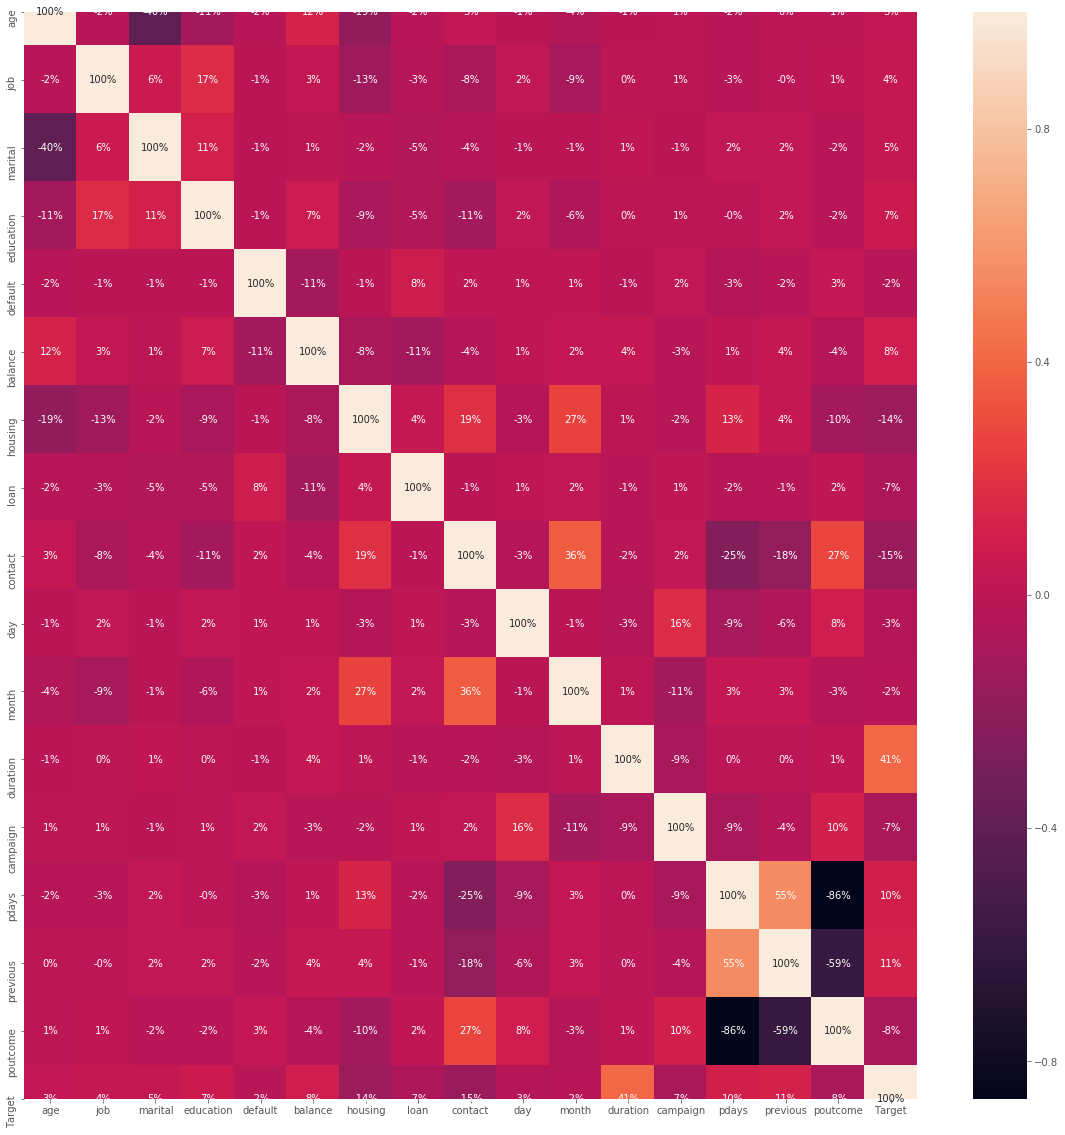

In [19]:
# Now let's create a heatmap of the correlated features (helps in visualization)

plt.figure(figsize=(20,20))  
sns.heatmap(df1.corr(), annot=True, fmt='.0%')

In [20]:
#Split the data into X and y variables
X = df1.drop('Target',axis=1)
y = df1['Target']

In [21]:
#Split the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.25, random_state=0)

#### First- Using Dummy Classifier to verify the inbalance data output


In [22]:
from sklearn.dummy import DummyClassifier
# DummyClassifier will end up predicting only target 0 which is NoSubscription
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

# checking unique labels
print('Unique predicted labels: ', np.unique(dummy_pred))

# checking accuracy
print('Test score: ', accuracy_score(y_test, dummy_pred))

Unique predicted labels:  [0]
Test score:  0.8827744846500929


#### First method - Now using Oversampling (Upsampling) method

In [23]:
# separate minority and majority classes
from sklearn.utils import resample
YesSubscription = df1[df1['Target']==1]
NoSubscription  = df1[df1['Target']==0]

In [24]:
# upsample minority
YesSubscription_upsampled = resample(YesSubscription,
                          replace=True, # sample with replacement
                          n_samples=len(NoSubscription), # match number in majority class
                          random_state=27) # reproducible results

In [25]:
# combine majority and upsampled minority
upsampled = pd.concat([NoSubscription, YesSubscription_upsampled])

In [26]:
upsampled.shape

(79844, 17)

In [27]:
# check new Target counts
upsampled.Target.value_counts()

1    39922
0    39922
Name: Target, dtype: int64

In [28]:
# Will first try logistic regression with the upsampled dataset - now balanced dataset
from sklearn.linear_model import LogisticRegression
y_train = upsampled.Target
X_train = upsampled.drop('Target', axis=1)
upsampled = LogisticRegression(solver='liblinear').fit(X_train, y_train)
upsampled_pred = upsampled.predict(X_test)

In [29]:
# Checking accuracy of Logistic Regression
accuracy_score(y_test, upsampled_pred)
from sklearn.metrics import classification_report
print('Logistic Regression classification_report')
print('...'*20)
print(classification_report(y_test,upsampled_pred))

Logistic Regression classification_report
............................................................
              precision    recall  f1-score   support

           0       0.97      0.81      0.88      9978
           1       0.35      0.78      0.48      1325

    accuracy                           0.80     11303
   macro avg       0.66      0.79      0.68     11303
weighted avg       0.89      0.80      0.83     11303



In [30]:
# confusion matrix for Logistic Regrssion with balanced data
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, upsampled_pred))

,0,1
0,8040,1938
1,286,1039


In [31]:
# Will now try second Random Forest classification with the upsampled dataset - now balanced dataset

from sklearn.ensemble import RandomForestClassifier

upsampled1 = pd.concat([NoSubscription, YesSubscription_upsampled])
X_train1 = upsampled1.drop('Target', axis=1)
y_train1 = upsampled1.Target

RFCupsampled = RandomForestClassifier(n_estimators= 1000, criterion="entropy", random_state = 0).fit(X_train1, y_train1)
RFCupsampled_pred = RFCupsampled.predict(X_test)
print("Random Forest Training Accuracy with upsampled data: {:.2f}%".format(RFCupsampled.score(X_train1, y_train1)*100))

Random Forest Training Accuracy with upsampled data: 100.00%


In [32]:
# Checking accuracy of RandomForest Classification with the upsampled dataset - now a balanced dataset
print("Random Forest Testing Accuracy with upsampled data: {:.2f}%".format(accuracy_score(y_test, RFCupsampled_pred)*100))
print('\n')
from sklearn.metrics import classification_report
print('Random Forest classification_report with upsampled data')
print('...'*20)
print(classification_report(y_test,RFCupsampled_pred))

Random Forest Testing Accuracy with upsampled data: 100.00%


Random Forest classification_report with upsampled data
............................................................
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9978
           1       1.00      1.00      1.00      1325

    accuracy                           1.00     11303
   macro avg       1.00      1.00      1.00     11303
weighted avg       1.00      1.00      1.00     11303



In [33]:
# confusion matrix of RandomForest Classification with the upsampled dataset - now a balanced dataset
pd.DataFrame(confusion_matrix(y_test, RFCupsampled_pred))

,0,1
0,9978,0
1,0,1325


#### Second step - Now using UnderSampling (DownSampling) method to balance the imbalanced dataset

In [34]:
# We are using the same separated classes YesSubscription and NoSubscription from above
# downsample majority
NoSubscription_downsampled = resample(NoSubscription,
                                replace = False, # sample without replacement
                                n_samples = len(YesSubscription), # match minority n
                                random_state = 27) # reproducible results

In [35]:
# combine minority and downsampled majority
downsampled = pd.concat([NoSubscription_downsampled, YesSubscription])
# checking counts
downsampled.Target.value_counts()

1    5289
0    5289
Name: Target, dtype: int64

In [36]:
# Will first try logistic regression classifier with the downsampled dataset - now balanced dataset
X_train = downsampled.drop('Target', axis=1)
y_train = downsampled.Target

undersampled = LogisticRegression(solver='liblinear').fit(X_train, y_train)
undersampled_pred = undersampled.predict(X_test)
undersampled_pred

array([0, 1, 0, ..., 0, 0, 1])

In [37]:
# Checking accuracy for Logistic regression classifier with downsampled dataset
accuracy_score(y_test, undersampled_pred)

0.8010262762098558

In [38]:
from sklearn.metrics import classification_report

print('Logistic Regression classification_report on DownSampling')
print('...'*20)
print(classification_report(y_test,undersampled_pred))

Logistic Regression classification_report on DownSampling
............................................................
              precision    recall  f1-score   support

           0       0.97      0.80      0.88      9978
           1       0.35      0.79      0.48      1325

    accuracy                           0.80     11303
   macro avg       0.66      0.79      0.68     11303
weighted avg       0.89      0.80      0.83     11303



In [39]:
# confusion matrix for Logistic Regrssion model with downsampled - balanced data
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, undersampled_pred))

,0,1
0,8012,1966
1,283,1042


In [40]:
# Will now try second Random Forest classification with the downsampled dataset - now balanced dataset
from sklearn.ensemble import RandomForestClassifier

downsampled1 = pd.concat([NoSubscription, YesSubscription_upsampled])
X_train1 = downsampled1.drop('Target', axis=1)
y_train1 = downsampled1.Target

RFCdownsampled = RandomForestClassifier(n_estimators= 1000, criterion="entropy", random_state = 0).fit(X_train1, y_train1)
RFCdownsampled_pred = RFCdownsampled.predict(X_test)
print("Random Forest Training Accuracy with downsampled data: {:.2f}%".format(RFCdownsampled.score(X_train1, y_train1)*100))

Random Forest Training Accuracy with downsampled data: 100.00%


In [41]:
from sklearn.metrics import classification_report

print('Random Forest classification_report on DownSampling')
print('...'*20)
print(classification_report(y_test,RFCdownsampled_pred))

Random Forest classification_report on DownSampling
............................................................
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9978
           1       1.00      1.00      1.00      1325

    accuracy                           1.00     11303
   macro avg       1.00      1.00      1.00     11303
weighted avg       1.00      1.00      1.00     11303



In [42]:
# confusion matrix for Random Forest classification model with downsampled - balanced data
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, RFCdownsampled_pred))

,0,1
0,9978,0
1,0,1325


#### Third method - SMOTE Generate Synthetic Samples
SMOTE(SMOTE or Synthetic Minority Oversampling Technique)
SMOTE or Synthetic Minority Oversampling Technique is a popular algorithm to creates sythetic observations of the minority class.

In [43]:
from imblearn.over_sampling import SMOTE

In [44]:
# Separate input features and target variable
X = df1.drop('Target', axis=1)
y = df1.Target

In [45]:
# setting up testing and training sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.25, random_state=27)
sm = SMOTE(random_state=27)
X_train1, y_train1 = sm.fit_sample(X_train1, y_train1)

In [46]:
#### First use smote with Logistic Regression
LRsmote = LogisticRegression(solver='liblinear').fit(X_train1, y_train1)
LRsmote_pred = LRsmote.predict(X_test1)

In [47]:
# Checking accuracy with LR model with SMOTE
accuracy_score(y_test1, LRsmote_pred)

0.8135008404848271

In [48]:
pd.DataFrame(confusion_matrix(y_test1, LRsmote_pred))

,0,1
0,8323,1691
1,417,872


In [49]:
#### Now we will use SMOTE with Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
RFCSmote = RandomForestClassifier(n_estimators=10).fit(X_train1, y_train1)

In [50]:
# predict on test set
RFCSmote_pred = RFCSmote.predict(X_test1)

In [51]:
#let's check the accuracy
accuracy_score(y_test1, RFCSmote_pred)

0.8789701849066619

In [52]:
# let's print the confusion matrix
pd.DataFrame(confusion_matrix(y_test1, RFCSmote_pred))

,0,1
0,9195,819
1,549,740


In [53]:
#from sklearn.naive_bayes import GaussianNB

In [54]:
###GridSearchCV-Support Vector Classifie

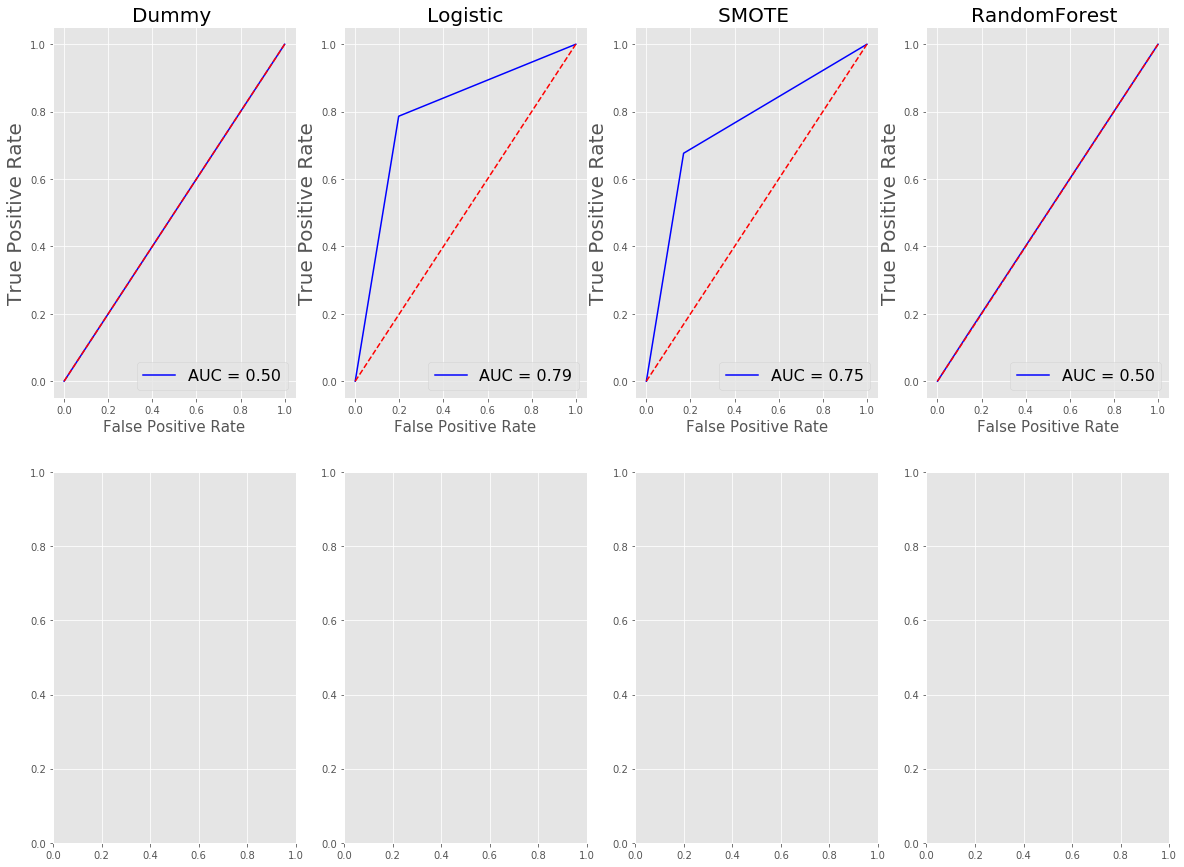

In [57]:
#Now determine the ROC and AUC 
fig, ax_arr = plt.subplots(nrows =2, ncols =4, figsize = (20,15))

#----------Dummy---------

dummy_pred = dummy.predict(X_test)
fprdm, tprdm, thresholddm = metrics.roc_curve(y_test,dummy_pred)
roc_aucxgb = metrics.auc(fprdm,tprdm)

ax_arr[0,0].plot(fprdm,  tprdm, 'b', label = 'AUC = %0.2f' % roc_aucxgb)
ax_arr[0,0].plot([0, 1], [0, 1],'r--')
ax_arr[0,0].set_title('Dummy ',fontsize=20)
ax_arr[0,0].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[0,0].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[0,0].legend(loc = 'lower right', prop={'size': 16})


#----------Logistic Regression---------

undersampled_pred = undersampled.predict(X_test)
fprlog, tprlog, thresholdlog = metrics.roc_curve(y_test, undersampled_pred)
roc_aucxgb = metrics.auc(fprlog, tprlog)

ax_arr[0,1].plot(fprlog, tprlog, 'b', label = 'AUC = %0.2f' % roc_aucxgb)
ax_arr[0,1].plot([0, 1], [0, 1],'r--')
ax_arr[0,1].set_title('Logistic',fontsize=20)
ax_arr[0,1].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[0,1].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[0,1].legend(loc = 'lower right', prop={'size': 16})


#----------SMOTE---------

LRsmote_pred = LRsmote.predict(X_test1)

fprsm, tprsm, thresholdsm = metrics.roc_curve(y_test1, LRsmote_pred)
roc_aucxgb = metrics.auc(fprsm, tprsm)


ax_arr[0,2].plot(fprsm, tprsm, 'b', label = 'AUC = %0.2f' % roc_aucxgb)
ax_arr[0,2].plot([0, 1], [0, 1],'r--')
ax_arr[0,2].set_title('SMOTE ',fontsize=20)
ax_arr[0,2].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[0,2].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[0,2].legend(loc = 'lower right', prop={'size': 16})

#----------Random Forest Classifier---------

RFCSmote_pred = RFCSmote.predict(X_test1)

fprfst, tprfst, thresholdfst = metrics.roc_curve(y_test, RFCSmote_pred)
roc_aucxgb = metrics.auc(fprfst, tprfst)


ax_arr[0,3].plot(fprfst, tprfst, 'b', label = 'AUC = %0.2f' % roc_aucxgb)
ax_arr[0,3].plot([0, 1], [0, 1],'r--')
ax_arr[0,3].set_title('RandomForest ',fontsize=20)
ax_arr[0,3].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[0,3].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[0,3].legend(loc = 'lower right', prop={'size': 16})
